In [18]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import math
import random
import os
from scipy.misc import imresize
from mammo_utils import remove_white_from_image, slice_normal_image, create_slices, read_pgm, get_roi_edges, get_fuzzy_offset, get_roi_edges, random_flip_image, progress
%matplotlib inline

In [105]:
def get_image_class(df, idx):
     # get the name of the image from the data
    img_name = df.loc[idx]['path']
    severity = df.loc[idx]['SEVERITY']
    img_class = df.loc[idx]['CLASS']
    
    if severity == "M":
        img_label = "MALIGNANT_"
        if img_class == "NORM":
            img_label = "NORMAL"
        elif img_class == "CALC":
            img_label = img_label + "calcification"
        else:
            img_label = img_label + "mass"
    elif severity == "B":
        img_label = "BENIGN_"
        if img_class == "CALC":
            img_label = img_label + "calcification"
        elif img_class == "NORM":
            img_label = "NORMAL"
        else:
            img_label = img_label + "mass"
    else:
        img_label = "NORMAL"
    
    return img_label

def trim_image_margins(img):
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    # get which columns are all black
    black_pixels = np.sum(img == 0, axis=0)
    
    blank_cols = (black_pixels >= (img_h - 10))
    
    # first trim from the left
    first_col = np.argmax(~blank_cols)
    
    # now trim from the right
    last_col = img_w - np.argmax(~np.flip(blank_cols, axis=0))
    #last_col = 0
    
    img = img[:,first_col:last_col]
    
    return img, first_col, last_col
    

## Copy of function used to crop cbis images, but will be altered to deal with MIAS images

## function to create ROI slices from masks and full images
## inputs: mask_dir and image_dir - paths to directories containing respective images
##         slice_size - size of slices to create
##         output - if True will output each file processed, 
##                  if False will only output errors and warnings, 
##                  if None won't ouput anything
## returns: numpy array of images and list of corresponding file names
def create_mias_slices(df, pgm_dir="E:\\Documents\\Mammography\\MIAS\\pgms\\", scale_by=2.5, slice_size=299, debug=None):
    # loop through rows in the data frame
    slices_list = []
    image_names_list = []
    labels_list = []
    full_slice_size = slice_size
    
    counter = 0
    if debug is None:
        progress(counter, len(df), 'WORKING')
    
    for index, row in all_cases_df.iterrows():
        
        # get the base file name from the mask name
        image_name = row['path']

        # create a progress bar
        counter += 1
        if debug is None:
            progress(counter,  len(df), image_name)
        
        # try to open the image, if it doesn't exist continue
        try:
            full_image_arr = read_pgm(pgm_dir + image_name)
        except:
            continue       
        
        # get rid of the extra dimensions with unneccessary info
        image_h, image_w = full_image_arr.shape
        
        # scale the image up by scale_by so it's on the same scale as the CBIS images
        new_size = int(image_h * scale_by)
        full_image_arr = imresize(full_image_arr, (new_size, new_size))
        
        ## Omit this, it was causing too many problems
        # trim the black margins of the image
        #full_image_arr, trim_first_col, trim_last_col = trim_image_margins(full_image_arr)
        
        # get the new shape of the image
        image_h, image_w = full_image_arr.shape
        
        # debug output
        if debug == True:
            print("Image:", image_name, "H:", image_h, "W:", image_w)
            
        # get the class of the image
        image_class = get_image_class(df, index)
        
        
        # if the image is abnormal
        if image_class != "NORMAL":
            # if the image doesn't have ROI data skip it
            if np.isnan(row['X']):
                continue
            
            # get the size and shape of the ROI, NOT offset by the number of columns trimmed off
            center_col = int(row['X'] * scale_by) # + trim_first_col
            center_row = image_h - int(row['Y'] * scale_by)

            # the ROI is square so we don't need to get the sizes individually
            roi_size = mask_height = mask_width = mask_size = row['RADIUS'] * scale_by

            ## add the ROI at normal size no matter what
            if True: 
                if debug:
                    print("Adding ROI at size", image_name)

                # if the ROI is smaller than the slice do some offsetting, otherwise leave it as is
                if roi_size <= (slice_size - 30):
                    fuzz_offset_h, fuzz_offset_w = get_fuzzy_offset(roi_size + 10, slice_size=slice_size)
                else:
                    fuzz_offset_h, fuzz_offset_w = 0, 0

                # define boundaries for the abnormality
                start_row, end_row, start_col, end_col = get_roi_edges(center_col, center_row, image_h, image_w, fuzz_offset_w, fuzz_offset_h, 1, slice_size=slice_size)

                # slice the ROI out of the image
                img_slice = full_image_arr[start_row:end_row, start_col:end_col]

                # cut the slice down to half size
                img_slice = imresize(img_slice, (slice_size,slice_size))

                # if the slice is the right shape add it to the list
                if img_slice.shape == (slice_size,slice_size):
                    slices_list.append(img_slice.reshape(slice_size,slice_size,1))
                    image_names_list.append(image_name)
                    labels_list.append(image_class)
                elif debug is not None:
                    print("Normal slice is wrong shape", image_name)

            ## if the ROI is too small cut out the full ROI and zoom it to size
            if roi_size <= slice_size // 1.5:
                if debug is not None:
                    print("Adding zoomed ROI", image_name)

                # Add a 10% margin to the ROI area
                roi_margin = int(roi_size * 0.10)
                roi_size_w_margin = int(roi_size + roi_margin)

                # set a lower bound to the zoom so we don't lose too much info by zooming in, 1.5x zoom seems a good max
                if roi_size_w_margin <= 200:
                    zoom_roi_size_w_margin = 200
                else:
                    zoom_roi_size_w_margin = roi_size_w_margin
                
                ## do this manually since it's easier to debug
                # get the edges of the ROI
                start_row = np.max([center_row - (zoom_roi_size_w_margin // 2), 0])
                end_row = start_row + zoom_roi_size_w_margin
                
                if end_row > image_h:
                    end_row = image_h
                    start_row = end_row - zoom_roi_size_w_margin
                
                start_col = np.max([center_col - (zoom_roi_size_w_margin // 2), 0])
                end_col = start_col + zoom_roi_size_w_margin
                
                if end_col > image_w:
                    end_col = image_w
                    start_col = end_col - zoom_roi_size_w_margin
                
                # slice the ROI out of the image
                try:
                    img_slice = full_image_arr[start_row:end_row, start_col:end_col]
                except:
                    print("Error", image_name, "Start Row:", start_row, "End Row:", end_row, "Start Col:", start_col, "End Col:", end_col)
                
                # make sure the slice is the right shape
                if img_slice.shape[0] == img_slice.shape[1]:
                    # resize it to 299x299 and add it to the list
                    img_slice = random_flip_image(imresize(img_slice, (slice_size,slice_size)))
                    slices_list.append(img_slice.reshape(slice_size,slice_size,1))
                    image_names_list.append(image_name)
                    labels_list.append(image_class)
                else:
                    print("Resized slice is wrong shape", image_name)

            ## if the ROI is bigger than a slice on either side, we will cut it out as tiles at regular size
            if roi_size > 299:
                if debug is not None:
                    print("Cutting ROI into tiles", image_name)

                # first define the corners of the ROI, making sure the ROI is at least as big as a slice should be
                if mask_height >= 299:
                    first_row = int(center_row - (mask_height // 2))
                    last_row = int(center_row + (mask_height // 2))
                else:
                    first_row = int(center_row - 149)
                    last_row = int(first_row + 299)

                if mask_width >= 299:
                    first_col = int(center_col - (mask_width // 2))
                    last_col = int(center_col + (mask_width // 2))
                else:
                    first_col = center_col - 149
                    last_col = first_col + 299

                # cut out the full ROI
                roi_img = full_image_arr[first_row:last_row,first_col:last_col]

                # cut the ROI into tiles of size 299x299, with a stride of 150
                tiles = [roi_img[x:x+slice_size,y:y+slice_size] for x in range(0,roi_img.shape[0],150) for y in range(0,roi_img.shape[1],150)]

                # loop through the tiles, if they are the right size size them down and add them to the list
                for tile in tiles:
                    if tile.shape[0] == tile.shape[1]:
                        img_slice = random_flip_image(imresize(tile, (slice_size,slice_size)))
                        slices_list.append(img_slice.reshape(slice_size,slice_size,1))
                        image_names_list.append(image_name)
                        labels_list.append(image_class)
        
        ## ELse if the image is normal
        else:
            if debug is not None:
                print(image_name, " creating tiles")
                
            # remove the margins
            full_image_arr, _, _ = trim_image_margins(full_image_arr)
            
            # remove 7% from each side of image to eliminate borders
            h, w = full_image_arr.shape
            hmargin = int(h * 0.07)
            wmargin = int(w * 0.07)
            img = full_image_arr[hmargin:h-hmargin, wmargin:w-wmargin]

            # slice the image into 299x299 tiles
            size = 299
            tiles = [img[x:x+size,y:y+size] for x in range(0,img.shape[0],size) for y in range(0,img.shape[1],size)]
            usable_tiles = []

            # for each tile:
            for i in range(len(tiles)):
                # make sure tile has correct shape
                if tiles[i].shape == (size,size):
                    # make sure the tile doesn't have too many white or black pixels, that indicates it is not useful
                    if (np.sum(np.sum(tiles[i] >= 225)) < 100) and (np.sum(np.sum(tiles[i] <= 20)) <= 50000):
                        # make sure tile has stuff in it
                        if np.mean(tiles[i]) >= 23:
                            # make sure the tile contains image and not mostly empty space
                            if np.var(tiles[i]) <= 1000:
                                if np.var(tiles[i]) >= 20:
                                    # flip a coin with probability 3/4 to keep the data balanced
                                    coin = np.random.binomial(1, 0.75)
                                    if coin:
                                        # reshape the tile so they will work with the convnet
                                        slices_list.append(tiles[i].reshape(slice_size,slice_size,1))
                                        image_names_list.append(image_name)
                                        labels_list.append(image_class)
        
        
    return np.array(slices_list), np.array(labels_list), image_names_list

In [106]:
# import and clean the annotation data, this time leave the duplicates
all_cases_df = pd.read_table('data/Info.txt', delimiter=' ')
all_cases_df = all_cases_df[all_cases_df.columns[:-1]] # drop last column
all_cases_df['path'] = all_cases_df['REFNUM'].map(lambda x: '%s.pgm' % x)

In [107]:
slices, labels, filenames = create_mias_slices(all_cases_df, debug=None)
print("Slices:", slices.shape)

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Slices: (2211, 299, 299, 1)==================================] 100.0% ...mdb322.pgm


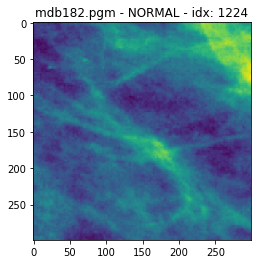

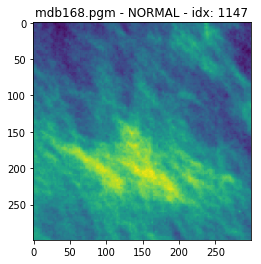

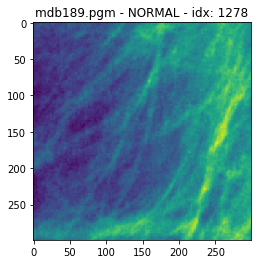

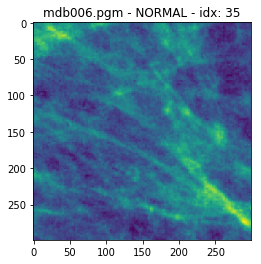

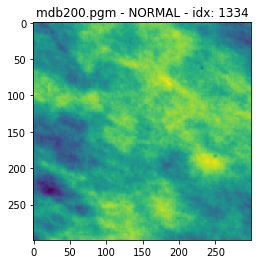

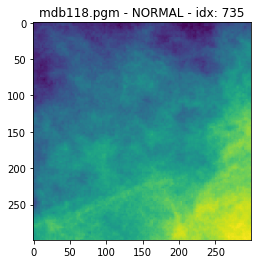

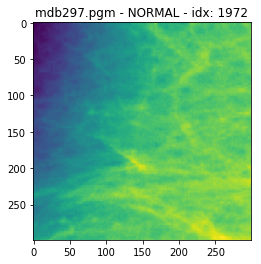

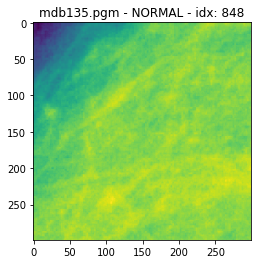

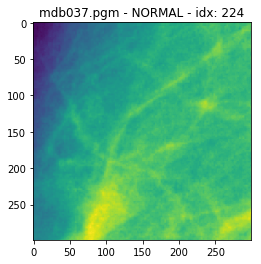

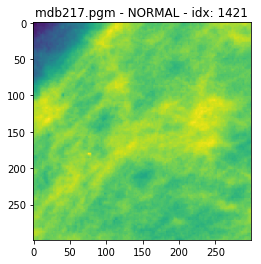

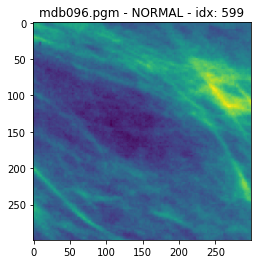

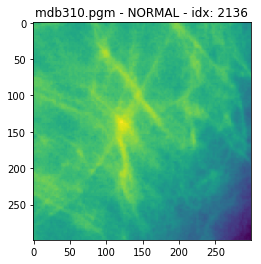

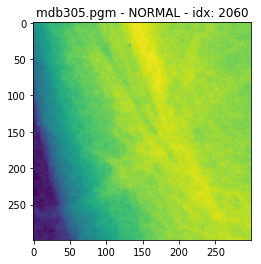

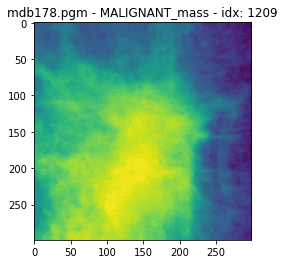

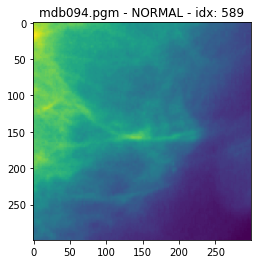

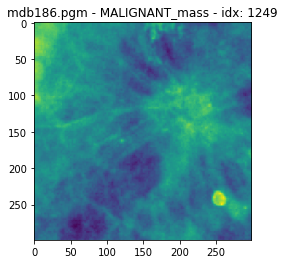

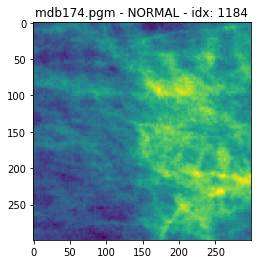

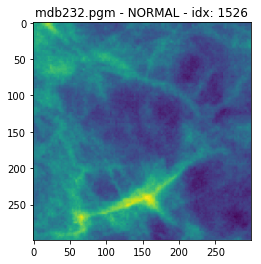

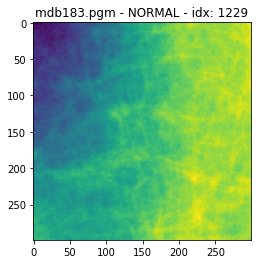

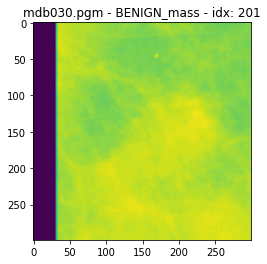

In [108]:
# look at some random images
N = 20
idxs = random.sample(range(len(slices)), k=N)

for idx in idxs:
    plt.imshow(slices[idx].reshape(299,299))
    plt.title(filenames[idx] + " - " + labels[idx] + " - idx: " + str(idx))
    plt.show()

In [109]:
pd.value_counts(labels)

NORMAL                     1973
BENIGN_mass                 111
MALIGNANT_mass               74
BENIGN_calcification         30
MALIGNANT_calcification      23
dtype: int64

In [110]:
## save the data
np.save(os.path.join("data", "all_mias_slices.npy"), slices)
np.save(os.path.join("data", "all_mias_labels.npy"), labels)
np.save(os.path.join("data", "all_mias_filenames.npy"), filenames)